In [1]:
from plotting_methods import *
from indices import var_cv, lc

### **Maps of individual ensemble members** [^](00_recreate-plot-explorer.ipynb)


#### **EuroCORDEX**

In [103]:
# load netcdf containing MANOVA data & extract DataArray
da = xr.open_dataset("example_data/tas_12km_stampplots-eurocordex_20491201-20791130_annual.nc")
da = xr.open_dataset("/data/met/plot-explorer/data/tas/tas_12km_stampplots-eurocordex_19890101-20081231_annual.nc")

da = da[list(da.data_vars)[0]] 

In [104]:
# flag whether evaluation runs & CMIP5 driving data are available (set manually to 0 to exclude from plots)
ecmwf = int(da.period == "19890101-20081231")
cmip = int("CMIP5" in da.ensemble)

# list of driving runs (full & short names), which determines order in which columns are presented
ec_gcms = {'CNRM-CERFACS-CNRM-CM5_r1i1p1': 'CNRM-CM5_r1i1p1',
           'ICHEC-EC-EARTH_r12i1p1': 'EC-EARTH_r12i1p1',
           'ICHEC-EC-EARTH_r1i1p1': 'EC-EARTH_r1i1p1',
           'ICHEC-EC-EARTH_r3i1p1': 'EC-EARTH_r3i1p1',
           'MOHC-HadGEM2-ES_r1i1p1': 'HadGEM2-ES_r1i1p1',
           'IPSL-IPSL-CM5A-MR_r1i1p1': 'IPSL-CM5A-MR_r1i1p1',
           'MPI-M-MPI-ESM-LR_r1i1p1': 'MPI-ESM-LR_r1i1p1',
           'MPI-M-MPI-ESM-LR_r2i1p1': 'MPI-ESM-LR_r2i1p1',
           'MPI-M-MPI-ESM-LR_r3i1p1': 'MPI-ESM-LR_r3i1p1',
           'NCC-NorESM1-M_r1i1p1': 'NorESM1-M_r1i1p1'}

# list of RCMs, which determines order in which rows are presented
ec_rcms = list(rcm_colours.keys())

In [105]:
# get range of values for colourbar, fix colour map
vlims = vrange(da)
cmap = fix_cmap(var_cv[da.name]["cmap"], **vlims)

# construct plot title & label for colour bar
if da.period == "19890101-20081231":
    cbar_label = "Bias in " + lc(var_cv[da.name]["plot_label"])
    plot_title = "Maps of bias in "+da.season.values[0]+" "+da.name+" for each run ("+da.period.values[0]+")"
elif da.period == "19801201-20101130":
    cbar_label = var_cv[da.name]["plot_label"]
    plot_title = "Maps of "+da.season.values[0]+" "+da.name+" for each run ("+da.period.values[0]+")"
else:
    cbar_label = "Change in " + lc(var_cv[da.name]["plot_label"])
    plot_title = "Maps of change in "+da.season.values[0]+" "+da.name+" for each run (19801201-20101130 - "+da.period.values[0]+")"


Text(0.5, 1.03, 'Maps of bias in annual tas for each run (19890101-20081231)')

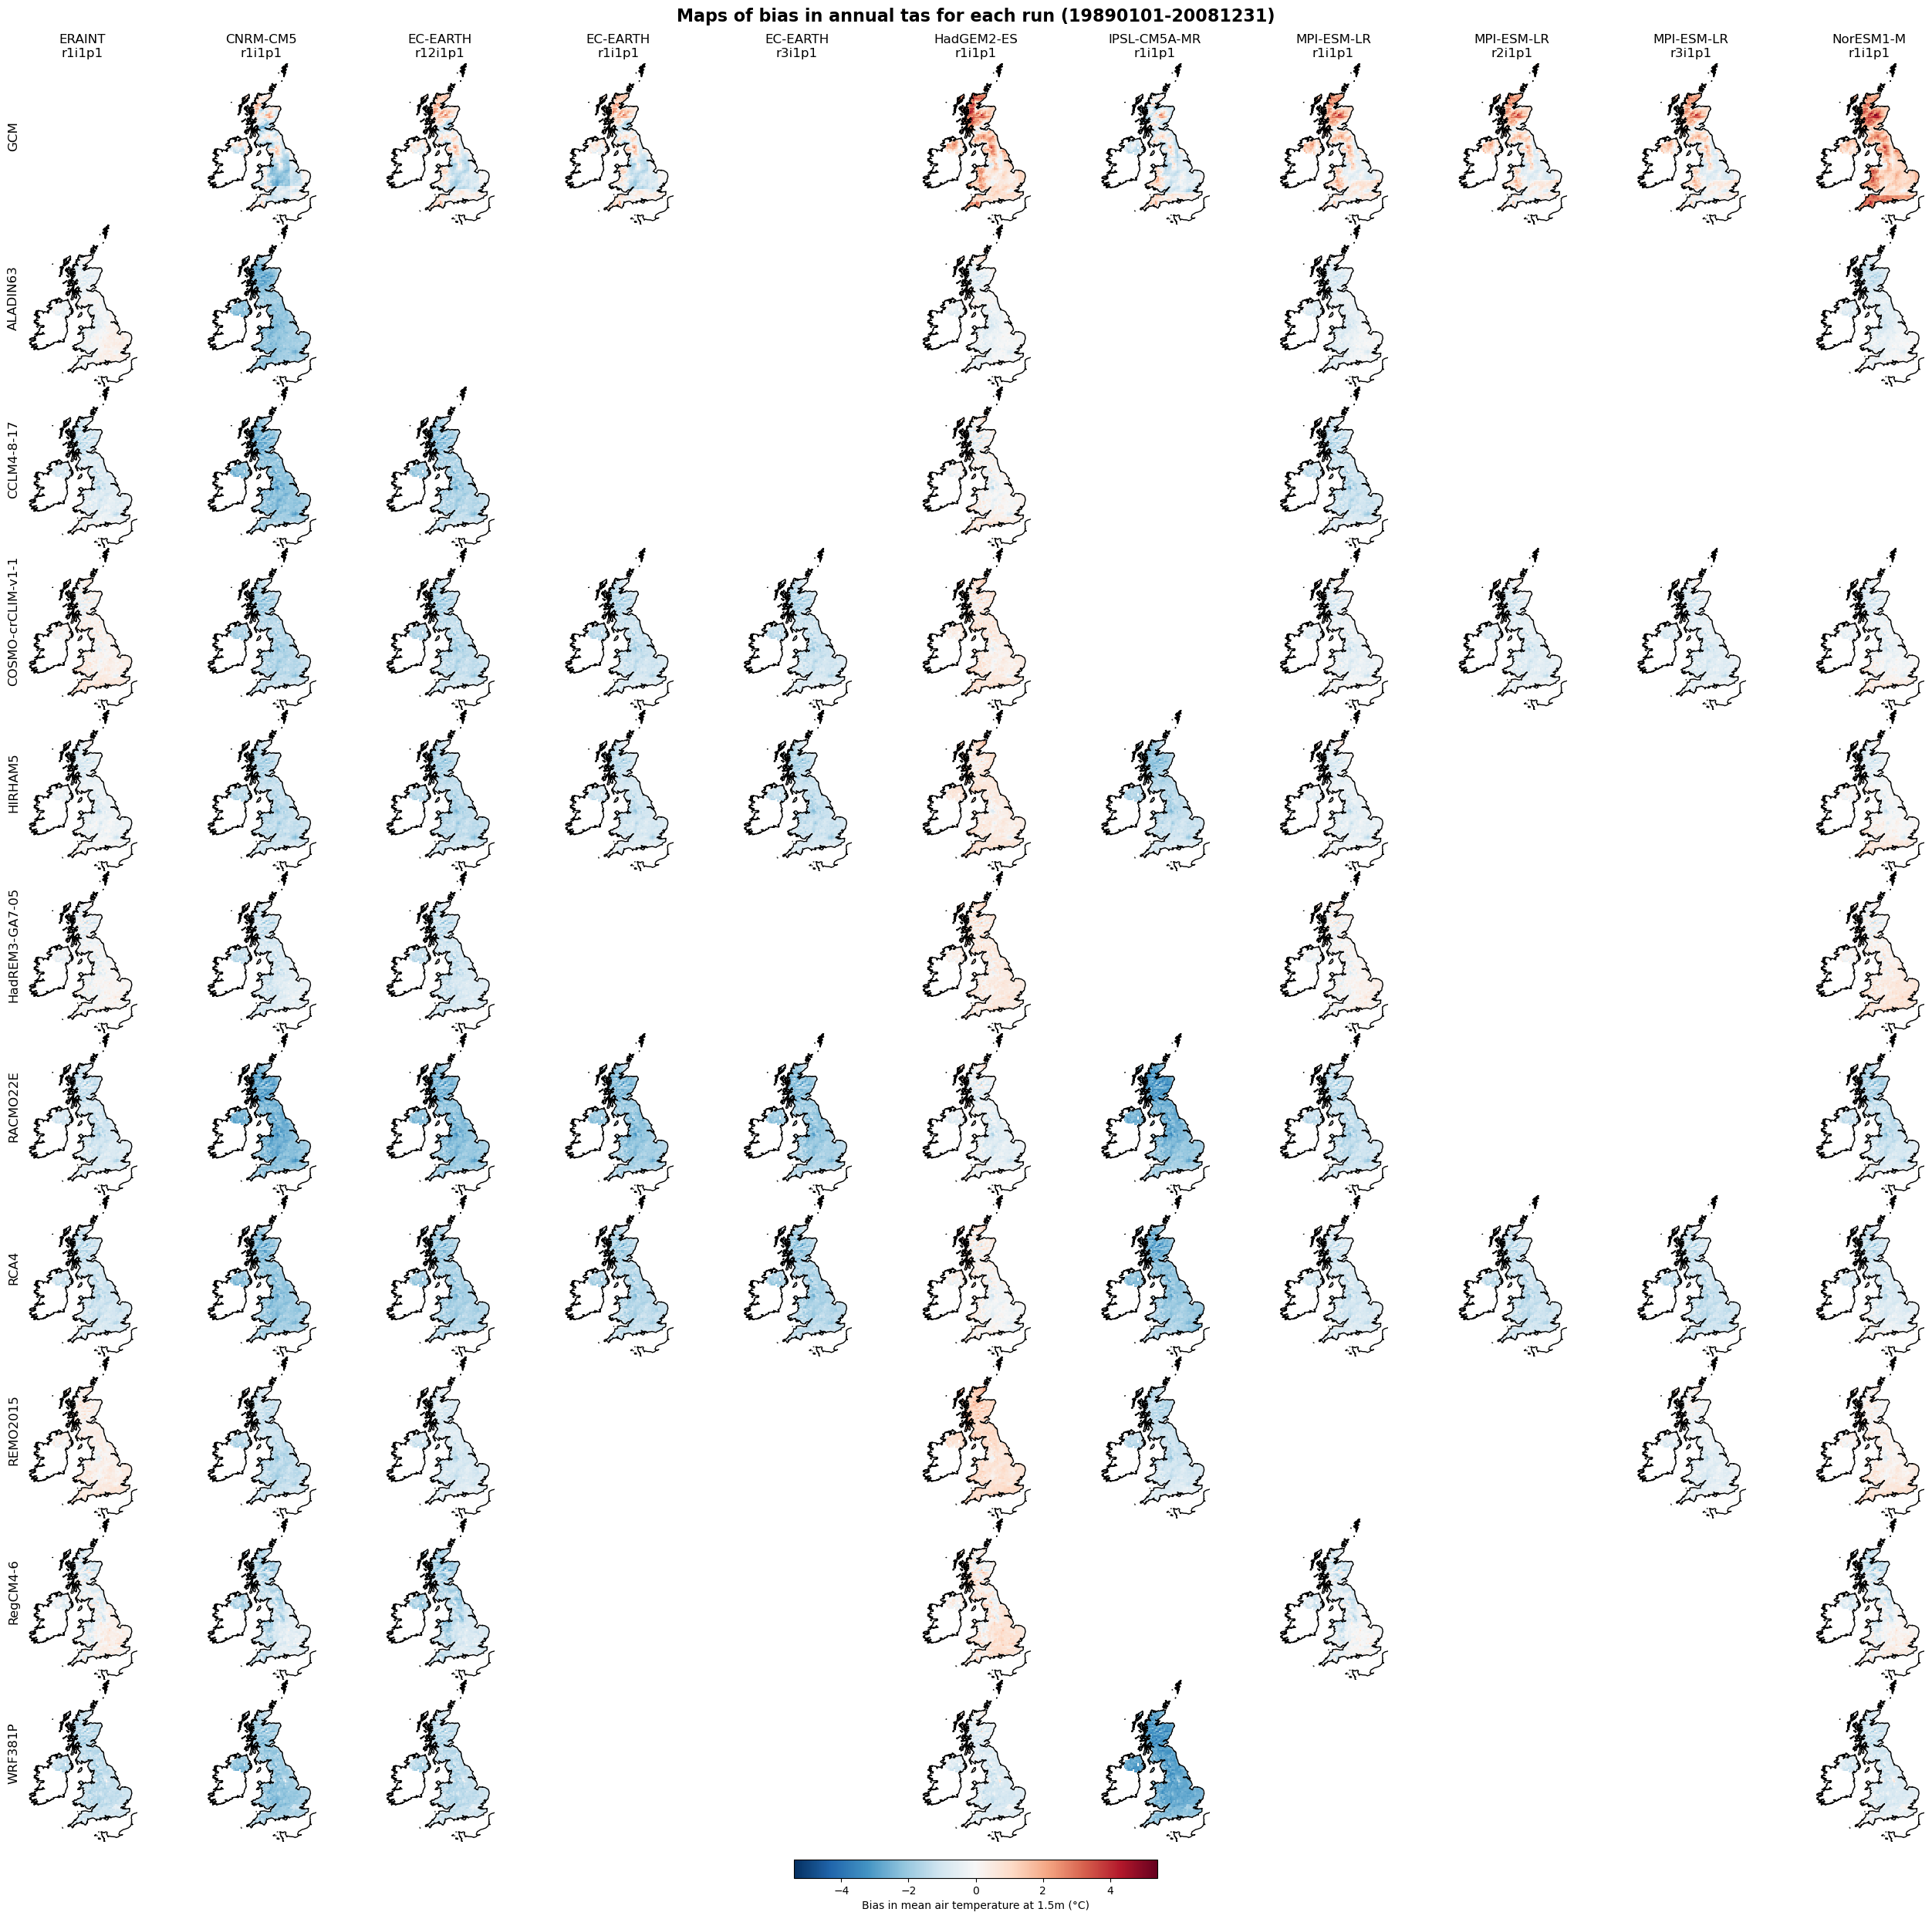

In [108]:
# create array of subplots with coastlines & correct projection
fig, axs = plt.subplots(ncols = 10 + ecmwf, nrows = 10 + cmip, figsize = (23 + 3*ecmwf, 24), sharex = True, sharey = True,
                        subplot_kw = { "projection" : crs_osgb}, dpi= 100, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace = 0, top = 1, left = 0.01, right = 0.99, bottom = 0.02)

# remove all axes & set spatial extent
for axz in fig.axes:
    axz.set_extent((-2e5, 7e5, -1e5, 12.2e5), crs = crs_osgb)
    axz.set_axis_off()
    
# plots of RCM runs
for rcm_nm in da.sel(run = da.ensemble == "EuroCORDEX").run.values:
    rcm_idx = ec_rcms.index(re.sub(".+_", "", rcm_nm))
    if "ECMWF" in rcm_nm and ecmwf:
        gcm_idx = 0
    else:
        gcm_idx = list(ec_gcms.keys()).index(re.sub("p1_.+","p1",rcm_nm)) + ecmwf
    ax = axs[rcm_idx+cmip, gcm_idx]
    
    cbar = da.sel(run = rcm_nm).plot(cmap = cmap, **vlims, add_colorbar = False, ax = ax)
    ax.set_title("")
    ax.coastlines(zorder = 99)
    
# add plots of GCM runs (if using)    
if cmip:
    for gcm_nm in da.sel(run = da.ensemble == "CMIP5").run.values:
        gcm_idx = list(ec_gcms.keys()).index([gcm for gcm in ec_gcms if gcm_nm in gcm][0]) + ecmwf
        ax = axs[0, gcm_idx]
        
        da.sel(run = gcm_nm).plot(cmap = cmap, **vlims, add_colorbar = False, ax = ax)
        ax.set_title("")
        ax.coastlines(zorder = 99)
        
    # add row label
    axs[0,0].text(-0.07, 0.55, "GCM", va='bottom', ha='center', rotation='vertical', rotation_mode='anchor', transform = axs[0,0].transAxes, fontsize = "large")
    
# add row & column titles
if ecmwf: axs[0,0].set_title("ERAINT\nr1i1p1")

for i in range(10): 
    axs[0,i+ecmwf].set_title(re.sub("_", "\n", list(ec_gcms.values())[i]))
    
for j in range(10):
    axs[j+cmip,0].text(-0.07, 0.55, ec_rcms[j], va='bottom', ha='center', rotation='vertical', rotation_mode='anchor',
                       transform = axs[j+cmip,0].transAxes, fontsize = "large")
    
plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.01, pad = 0.01, label = cbar_label)

plt.suptitle(plot_title, fontweight = "bold", y = 1.03, fontsize = 16)